In [1]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer

My implementation of the logistic regression algorithm (`logistic.py`) can be found [here](https://github.com/lawolff1702/lawolff1702.github.io/blob/6874e132c1512ee08a467716264a248c9d57cc77/posts/Implementing%20Logistic%20Regression/logistic.py).

# Abstract

--- insert here ---

# Implementation

The logistic regression model I implemented minimizes the binary cross-entropy loss to classify data. During training, we use momentum to help the model move more quickly in the right direction by combining the current gradient with a fraction of the previous update as we try search the loss-space for a minimum. The momentum should help reduce oscillations and speed up convergence! Lets see how it works!

# Exploration

We will start with **vanilla gradient descent**. We will be working with two-dimensional data (x1, x2) and setting our $\beta$ value to zero to nullify the momentum term.

The code below provides functions to generate and plot data for a classification problem that we can address using our model. To test our vanilla model, lets generate some linearly separable data!

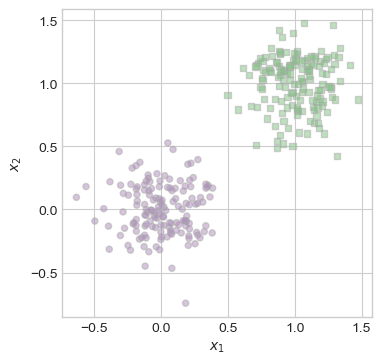

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

# torch.manual_seed(67)

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

def plot_lr_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "PRGn", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
X, y = classification_data(noise = 0.2, p_dims = 2)
plot_lr_data(X, y, ax)

In [3]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss_vec_vanilla = []
max_iter = 1000

for _ in range(max_iter): 
    loss = LR.loss(X, y)
    loss_vec_vanilla.append(loss)

    opt.step(X, y, alpha=0.45, beta=0)

loss

tensor(0.0148)

**ASK IN OFFICE HOURS WHY IT ISNT 0**

Thats great! Looks like we were able to separate the data by achieving a minimal loss! Lets take a look at the line that separates our points.

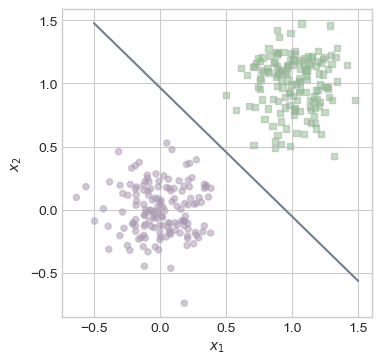

In [4]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_lr_data(X, y, ax)
draw_line(LR.w, x_min = -0.5, x_max = 1.5, ax = ax, color = "slategrey")

As seen above, our line very handily separates the two classes of points. Lets take a look at how our loss evolved over time by plotting our loss at each step.

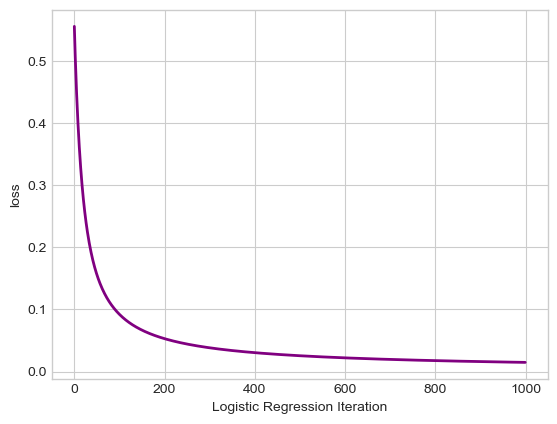

In [5]:
plt.plot(loss_vec_vanilla, color = "purple", lw=2)
# plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "purple")
labs = plt.gca().set(xlabel = "Logistic Regression Iteration", ylabel = "loss")

It is interesting to note that our Logistic Regression is not jumping around as we observed with the Perceptron algorithm in the [previous blog post](https://lawolff1702.github.io/posts/Implementing%20the%20Perceptron%20Algorithm/). On the contrary, using gradient descent on a convex loss function, we are slowly advancing towards the minimum of the function.

Now lets look at how **momentum** can help us! We will use the same dataset, however, this time we will instantiate a model with a $\beta=0.9$.

In [6]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss_vec_momentum = []

for _ in range(max_iter): 
    loss = LR.loss(X, y)
    loss_vec_momentum.append(loss)

    opt.step(X, y, alpha=0.45, beta=0.9)

loss

tensor(0.0023)

Lets see how these processes stack up against each other. For the graph we are 

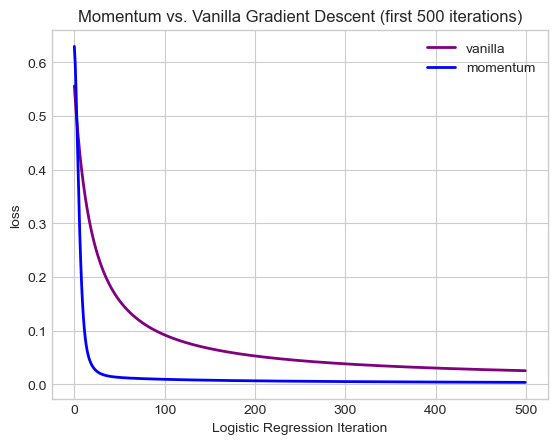

In [7]:
num_iter = 500
plt.plot(loss_vec_vanilla[:num_iter], color = "purple", lw=2, label = "vanilla")
plt.plot(loss_vec_momentum[:num_iter], color = "blue", lw=2, label = "momentum")
labs = plt.gca().set(xlabel = "Logistic Regression Iteration", ylabel = "loss", title = f"Momentum vs. Vanilla Gradient Descent (first {num_iter} iterations)")
plt.legend()

As we can see, including a momentum factor helps the model narrow in on the minimum loss a lot faster! When we use vanilla, we are updating our weight vector only using teh current gradient. However, with momentum we are also considering the direction of the previous update, so we build up momentum when we are going the right direction which helps us find the minimum faster.

Next, we are going to take a look at some issues pertaining to **overfitting** our model. We are going to generate data where the the number of features is higher than the number of points we have, `p_dim > n_points`. To illustrate the issues of overfitting, we will generate separate testing and validation data sets, then compare their accuracy. 

In [8]:
X_train, y_train = classification_data(noise = 1.2, p_dims = 100, n_points = 50)
X_test, y_test = classification_data(noise = 1.2, p_dims = 100, n_points = 50)

Here is a small helper function to calculate our accuracy.

In [9]:
def acc(model, X, y):
    y_hat = model.predict(X)
    return (y_hat == y).float().mean().item()

Now lets train a model that achieves 100% training accuracy!

In [10]:
LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)

train_loss = []
test_loss = []

for _ in range(50):
    train_loss.append(LR.loss(X_train, y_train))
    test_loss.append(LR.loss(X_test, y_test))

    opt.step(X_train, y_train, alpha=0.5, beta=0.9)
    
train_acc = acc(LR, X_train, y_train)
print(f"Training Accuracy: {train_acc * 100:.2f}% Training Loss: {LR.loss(X_train, y_train):.4f}")


Training Accuracy: 100.00% Training Loss: 0.0000


Voila! This seems amazing! We have 100% accuracy and a very low loss! However, our testing data may not ignite the same happiness within us.

In [11]:
test_acc = acc(LR, X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}% Test Loss: {LR.loss(X_test, y_test):.4f}")

Test Accuracy: 78.00% Test Loss: 1.5264


Youch. This is a lot lower accuracy that we would have liked. In addition, the testing loss is quite high! Lets have a look at how our model performs at each iteration.

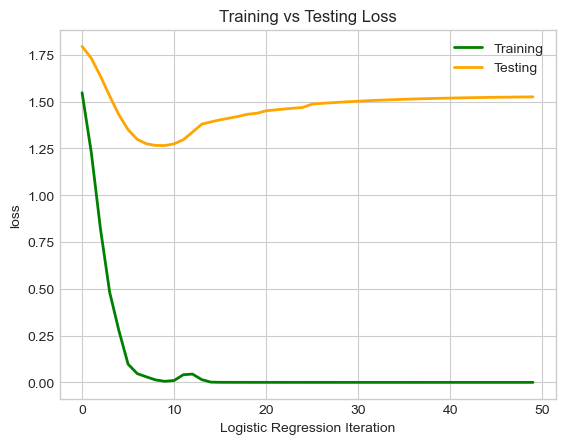

In [12]:
plt.plot(train_loss, color = "green", lw=2, label = "Training")
plt.plot(test_loss, color = "orange", lw=2, label = "Testing")
labs = plt.gca().set(xlabel = "Logistic Regression Iteration", ylabel = "loss", title = f"Training vs Testing Loss")
plt.legend()

We can see our training loss decrease and converge to zero, however, at a certain point our testing loss that was once decreasing too, begins to increase! The model continues to learn (and thus overfit) the training data, even as it starts to perform worse on generalizing to new data. When we have a higher number of features than we do samples, overfitting can become problematic as it did above.

# Predicting World Cup Match Winners

To illustrate our Logistic Regression model on some empirical data, we are going to use [World Cup Match Data](https://www.kaggle.com/datasets/brenda89/fifa-world-cup-2022?resource=download) and try and predict match winners! The dataset we are using was compiled on Kaggle by Brenda Loznik in 2022 from publicly available FIFA World Cup data. Players were manually classified as either goalkeeper, defender, midfielder, or offensive player. For each team, only the top-performing players were selected. These plater statistics were used to create the power scores for each team. In some cases, data is missing — this indicates that a country did not have enough qualifying players to met the selection criteria. Additionally, the dataset assumes that each season runs from September to the following August.

In [13]:
import pandas as pd
df = pd.read_csv('international_matches.csv')
df.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,1993-08-08,Bolivia,Uruguay,South America,South America,59,22,0,0,3,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-08-08,Brazil,Mexico,South America,North America,8,14,0,0,1,...,No,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-08-08,Ecuador,Venezuela,South America,South America,35,94,0,0,5,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-08-08,Guinea,Sierra Leone,Africa,Africa,65,86,0,0,1,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-08-08,Paraguay,Argentina,South America,South America,67,5,0,0,1,...,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Below are the training features we will be using, I selected mainly score based features like rank, points, and positional scores because I thought they would work best.

In [40]:
features = [
    'home_team_fifa_rank',
    'away_team_fifa_rank',
    'home_team_total_fifa_points',
    'away_team_total_fifa_points',
    'home_team_goalkeeper_score',
    'home_team_mean_defense_score',
    'home_team_mean_offense_score',
    'home_team_mean_midfield_score',
    'away_team_goalkeeper_score',
    'away_team_mean_defense_score',
    'away_team_mean_offense_score',
    'away_team_mean_midfield_score'
]

Here is a first look at our raw data. Lets do some quick preprocessing to clean the dataset to make sure we have data in all fields, create a target vector, etc.

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df_wc = df[df['tournament'].str.contains("World Cup", case=False)]
df_wc_clean = df_wc.dropna()
df_wc_clean = df_wc_clean[df_wc_clean['home_team_result'] != 'Draw']
df_wc_clean = df_wc_clean[df_wc_clean['shoot_out'] == 'No']
le.fit(df_wc_clean["home_team_result"])
df_wc_clean["home_team_result"] = le.transform(df_wc_clean["home_team_result"])

X_features = torch.tensor(df_wc_clean[features].values, dtype=torch.float32)
y_tensor = torch.tensor(df_wc_clean["home_team_result"].values, dtype=torch.float32)

# Add bias term
X_tensor = torch.cat((X_features, torch.ones((X_features.shape[0], 1))), 1)

# Now split into train/val/test sets
X_train_tensor, X_temp_tensor, y_train_tensor, y_temp_tensor = train_test_split(X_tensor, y_tensor, test_size=0.4, random_state=72, stratify=y_tensor)
X_val_tensor, X_test_tensor, y_val_tensor, y_test_tensor = train_test_split(X_temp_tensor, y_temp_tensor, test_size=0.5, random_state=72, stratify=y_temp_tensor)

I selected only World Cup Matches, dropped the matches with missing data, dropped all the matches that ended in a draw or went to penalties, and made a binary encoding for who won the match. Finally I created training, validation, and testing split. Our target value is `home_team_result`.

Lets go ahead and train our model! Lets first do **without momentum** then with momentum!

In [96]:
LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)

max_iter = 1000

train_loss = []
val_loss = []

for _ in range(max_iter):
    train_loss.append(LR.loss(X_train_tensor, y_train_tensor))
    val_loss.append(LR.loss(X_val_tensor, y_val_tensor))

    opt.step(X_train_tensor, y_train_tensor, alpha=0.1, beta=0)
    
train_acc = acc(LR, X_train_tensor, y_train_tensor)
val_acc = acc(LR, X_val_tensor, y_val_tensor)
print(f"Training Accuracy: {train_acc * 100:.2f}% Training Loss: {LR.loss(X_train_tensor, y_train_tensor):.4f}")
print(f"Validation Accuracy: {val_acc * 100:.2f}% Validation Loss: {LR.loss(X_val_tensor, y_val_tensor):.4f}")

Training Accuracy: 70.64% Training Loss: 4.6897
Validation Accuracy: 76.37% Validation Loss: 3.7726


This is pretty good considering the nature of football! However, our loss remains quite high... Let's see how we perform on our testing data:

In [97]:
test_acc = acc(LR, X_test_tensor, y_test_tensor)
print(f"Test Accuracy: {test_acc * 100:.2f}% Test Loss: {LR.loss(X_test_tensor, y_test_tensor):.4f}")

Test Accuracy: 70.33% Test Loss: 4.7601


We are still performing well on unseen data! That is a great sign for a model. Let's explore how using momentum will affect the model

In [100]:
LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)

max_iter = 1000

train_loss_m = []
val_loss_m = []

for _ in range(max_iter):
    train_loss_m.append(LR.loss(X_train_tensor, y_train_tensor))
    val_loss_m.append(LR.loss(X_val_tensor, y_val_tensor))

    opt.step(X_train_tensor, y_train_tensor, alpha=0.1, beta=0.9)
    
train_acc = acc(LR, X_train_tensor, y_train_tensor)
val_acc = acc(LR, X_val_tensor, y_val_tensor)
test_acc = acc(LR, X_test_tensor, y_test_tensor)

print(f"Training Accuracy: {train_acc * 100:.2f}% Training Loss: {LR.loss(X_train_tensor, y_train_tensor):.4f}")
print(f"Validation Accuracy: {val_acc * 100:.2f}% Validation Loss: {LR.loss(X_val_tensor, y_val_tensor):.4f}")
print(f"Test Accuracy: {test_acc * 100:.2f}% Test Loss: {LR.loss(X_test_tensor, y_test_tensor):.4f}")

Training Accuracy: 71.56% Training Loss: 4.5244
Validation Accuracy: 70.88% Validation Loss: 4.6493
Test Accuracy: 74.73% Test Loss: 4.0400


Unfortunately, momentum didn't help us much here. It seems pretty hard to get above ~70% accuracy and ~4.0 loss with the given data. This could be attributed to the fact that soccer datasets are definitely not linearly separable or close to it. Lets take a look at how our model's loss evolved.

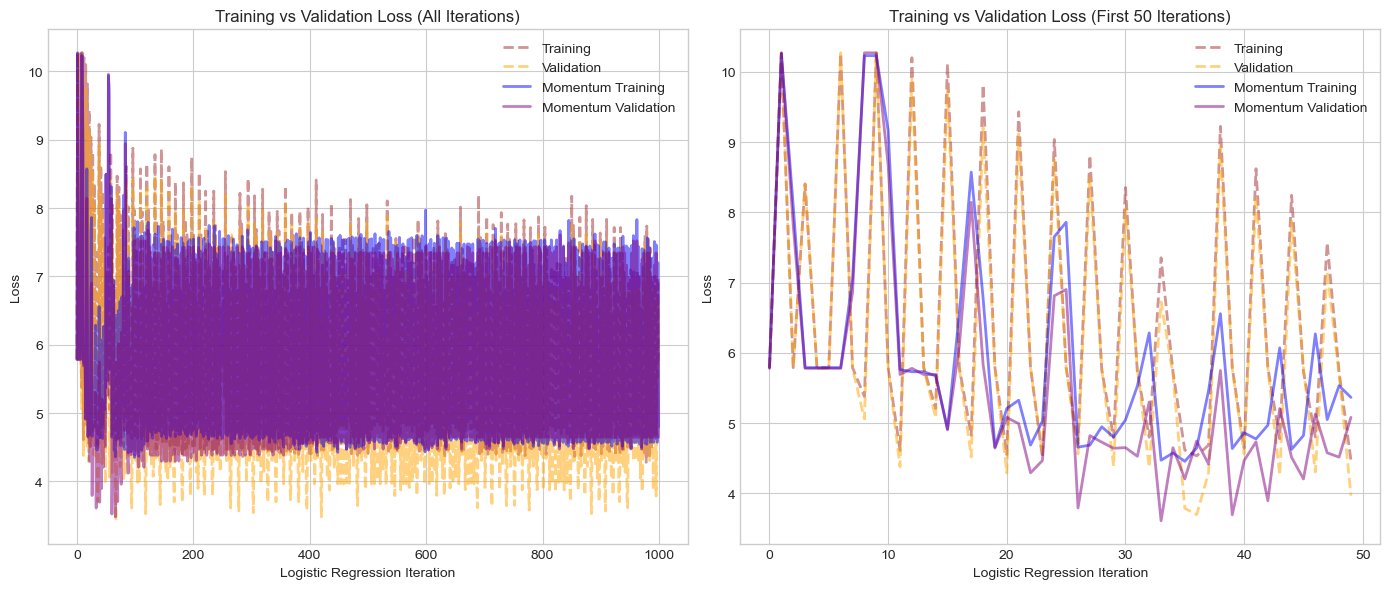

In [112]:
first = 50
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

axes[0].plot(train_loss, "--", color="brown", lw=2, label="Training", alpha=0.5)
axes[0].plot(val_loss, "--", color="orange", lw=2, label="Validation", alpha=0.5)
axes[0].plot(train_loss_m, color="blue", lw=2, label="Momentum Training", alpha=0.5)
axes[0].plot(val_loss_m, color="purple", lw=2, label="Momentum Validation", alpha=0.5)
axes[0].set_title("Training vs Validation Loss (All Iterations)")
axes[0].set_xlabel("Logistic Regression Iteration")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(train_loss[:first], "--", color="brown", lw=2, label="Training", alpha=0.5)
axes[1].plot(val_loss[:first], "--", color="orange", lw=2, label="Validation", alpha=0.5)
axes[1].plot(train_loss_m[:first], color="blue", lw=2, label="Momentum Training", alpha=0.5)
axes[1].plot(val_loss_m[:first], color="purple", lw=2, label="Momentum Validation", alpha=0.5)
axes[1].set_title(f"Training vs Validation Loss (First {first} Iterations)")
axes[1].set_xlabel("Logistic Regression Iteration")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()
plt.show()

We can see here that momentum helped us smooth our the loss curve slightly, but didn't really help with our convergence speed. There are a myriad of reasons why we observe this behavior. The data may be quite noisy, so to speak, or our parameters may not by optimized for the problem. 